# turbidity classification

- Resnet을 이용해, color(0,1,2) 분류
- settings

```
1. random oversampling
2. early stopping
3. kfold (미정)
```


In [1]:
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import torchvision.models as models
import cv2


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import sys
from tqdm import tqdm

In [2]:
# import early stop

p = os.path.abspath('../utils') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.12.1  Device :  cuda


# 데이터 분류

## train / valid / test

In [4]:
#1. train, test 나누기

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


datas = glob('../data/bmc/*.jpg')
label_df = pd.read_csv('../bmc.csv')

#첫번째 열 이름 바꿔주기
column_names = list(label_df.columns)
column_names[0]='file_name'
label_df.columns = column_names

X = list(label_df['file_name'])
Y = list(label_df['label'])

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)



print("---")
print("훈련 셋 : ",len(Y_train),Counter(Y_train))
print("검증 셋 : ",len(Y_valid),Counter(Y_valid))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")


---
훈련 셋 :  692 Counter({2: 265, 0: 253, 1: 174})
검증 셋 :  174 Counter({2: 67, 0: 64, 1: 43})
테스트 셋 :  217 Counter({2: 84, 0: 79, 1: 54})
---


In [5]:
label_df

,file_name,origin_name,color,residue,turbidity,label
0,0,1301837407-1,0,0,0,0
1,1,1411450810-1,0,0,0,0
2,2,1651193832-1,0,0,0,0
3,3,2077897036-1,0,0,0,0
4,4,290980310-1,0,1,0,0
...,...,...,...,...,...,...
1078,1078,PANO_20200407_221523,2,2,1,2
1079,1079,PANO_20200407_221527,2,2,1,2
1080,1080,PANO_20200818_174909,2,2,1,2
1081,1081,PANO_20210330_062718,2,2,1,2


In [6]:
set(label_df['turbidity'])

{0, 1}

## random over sampling

In [7]:
# 계획 x. label 기준으로 오버셈플링 예정

# 데이터 정의

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class BowelDataset(Dataset):
    def __init__(self, data_path_list,to_tensor,transform):
        self.data_path_list = data_path_list
        self.label = BowelDataset.get_label(self.data_path_list)
        self.to_tensor = to_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data_path_list)
    
    @classmethod
    def get_label(cls, data_path_list):
        label_list=[]
        for x in data_path_list:
            #이 부분 더 빠르게 못고치나?
            #multi label
            #color	residue	turbidity	label
            row=label_df[label_df["file_name"]==x]
            multilabels=row[["color","residue","turbidity","label"]].values[0].tolist()
            label_list.append( multilabels  )
        return label_list

    def __getitem__(self, idx):
        file_id=self.data_path_list[idx]
        file_path = "../data/bmc/{0:04d}.jpg".format(file_id)
        image = cv2.imread( file_path )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image=self.to_tensor(image)
        if self.transform:
            #1. 이미지 사이즈 변환
            image=self.transform(image).type(torch.float32)# 이미지 0~1 정규화
        return image, torch.tensor(self.label[idx][1])
        
        

In [9]:

#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 16개 이미지
EPOCHS = 50 # 전체 데이터 셋을 50번 반복
lr=1e-4

In [10]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.


train_loader = torch.utils.data.DataLoader(dataset = 
                                           BowelDataset(X_train,
                                                       to_tensor = transforms.ToTensor(),
                                                       transform = torch.nn.Sequential(
                                                            transforms.Resize([512,512]),
                                                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                        )
                                                      ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           num_workers=0
                                           ) # 순서가 암기되는것을 막기위해.
valid_loader = torch.utils.data.DataLoader(dataset = 
                                           BowelDataset(X_valid,
                                                       to_tensor = transforms.ToTensor(),
                                                       transform = torch.nn.Sequential(
                                                            transforms.Resize([512,512]),
                                                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                        )
                                                      ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,) # 순서가 암기되는것을 막기위해.


test_loader = torch.utils.data.DataLoader(dataset = 
                                           BowelDataset(X_test,
                                                       to_tensor = transforms.ToTensor(),
                                                       transform = torch.nn.Sequential(
                                                            transforms.Resize([512,512]),
                                                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                        )
                                                      ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,) # 순서가 암기되는것을 막기위해.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

X_train :  torch.Size([32, 3, 512, 512]) type: torch.FloatTensor
Y_train :  torch.Size([32]) type: torch.LongTensor


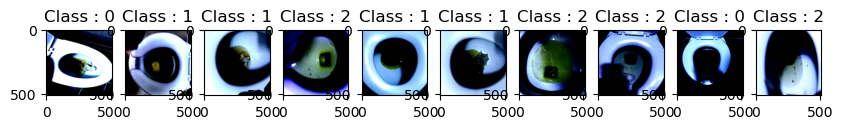

In [11]:

# 4. 데이터 확인하기
#현재 이미지 문제점 : 검게 출력되는 이미지들이 보인다.

for (X_train_sample,Y_train_sample) in train_loader:
    print("X_train : ",X_train_sample.size(),'type:',X_train_sample.type())
    print("Y_train : ",Y_train_sample.size(),'type:',Y_train_sample.type())
    break

pltsize = 1
plt.figure(figsize=(10*pltsize,pltsize))#하나당 10,1

for i in range(10):
    plt.subplot(1,10,i+1)
    transposed_img = np.transpose(X_train_sample[i].detach().numpy(),(1,2,0))
    plt.imshow(transposed_img )# 배치에서 10개만 추출
    plt.title('Class : '+str(Y_train_sample[i].item()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


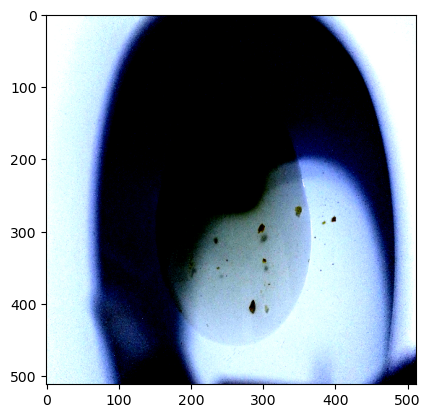

In [12]:
transposed_img=np.transpose(X_train_sample[i].detach().numpy(),(1,2,0))
plt.imshow(transposed_img )

# 모델 설계

- 기본 resnet18

In [13]:
# pretrained

class ResLayer(nn.Module):
    def __init__(self,):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(weights='IMAGENET1K_V1').cuda() 
        self.num_ftrs = self.model.fc.out_features
        
        
        
        self.fc = nn.Sequential(
            #nn.BatchNorm1d(self.num_ftrs+self.n_mfcc),                
            nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,3)
                            )
        

    def forward(self, x):
        x = self.model(x)
        x  = self.fc(x)
        return x
    
def model_initialize():
    model = ResLayer().cuda()
    return model

In [14]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in tqdm(enumerate(train_loader)):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [15]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image,label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [22]:
check_path = './checkpoint/baseline_getturbidity_'+'resnet18'+'_512_'+'.pt'
print(check_path)
early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)

best_train_acc=0 # accuracy 기록용
best_valid_acc=0

model=model_initialize()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)



print("학습 시작")
for Epoch in range(1,EPOCHS+1):
    train_loss,train_accuracy = train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_accuracy = evaluate(model, valid_loader)

    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
          format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))


    early_stopping(valid_loss, model)
    if -early_stopping.best_score == valid_loss:
        best_train_acc, best_valid_acc = train_accuracy,valid_accuracy

    if early_stopping.early_stop:
            #train_accs.append(best_train_acc)
            #valid_accs.append(best_valid_acc)
            #print("[{} 교차검증] Early stopping".format(data_ind))
            break

    if Epoch==EPOCHS:
        #만약 early stop 없이 40 epoch라서 중지 된 경우. 
        train_accs.append(best_train_acc)
        valid_accs.append(best_valid_acc)

./checkpoint/baseline_getcolor_resnet18_512_.pt
학습 시작


22it [02:10,  5.91s/it]



[EPOCH:1]	 Train Loss:0.0323	 Train Acc:46.97 %  | 	Valid Loss:0.0302 	Valid Acc: 73.56 %

Validation loss decreased (inf --> 0.030211).  Saving model ...


22it [02:03,  5.63s/it]



[EPOCH:2]	 Train Loss:0.0266	 Train Acc:64.45 %  | 	Valid Loss:0.0264 	Valid Acc: 81.61 %

Validation loss decreased (0.030211 --> 0.026425).  Saving model ...


22it [02:04,  5.66s/it]



[EPOCH:3]	 Train Loss:0.0246	 Train Acc:71.10 %  | 	Valid Loss:0.0219 	Valid Acc: 89.08 %

Validation loss decreased (0.026425 --> 0.021902).  Saving model ...


22it [02:04,  5.65s/it]



[EPOCH:4]	 Train Loss:0.0222	 Train Acc:77.02 %  | 	Valid Loss:0.0210 	Valid Acc: 89.08 %

Validation loss decreased (0.021902 --> 0.020993).  Saving model ...


22it [02:06,  5.73s/it]



[EPOCH:5]	 Train Loss:0.0200	 Train Acc:81.79 %  | 	Valid Loss:0.0215 	Valid Acc: 90.23 %

EarlyStopping counter: 1 out of 5


22it [02:06,  5.76s/it]



[EPOCH:6]	 Train Loss:0.0181	 Train Acc:85.98 %  | 	Valid Loss:0.0189 	Valid Acc: 91.38 %

Validation loss decreased (0.020993 --> 0.018877).  Saving model ...


22it [02:06,  5.73s/it]



[EPOCH:7]	 Train Loss:0.0161	 Train Acc:92.34 %  | 	Valid Loss:0.0203 	Valid Acc: 89.08 %

EarlyStopping counter: 1 out of 5


22it [02:00,  5.49s/it]



[EPOCH:8]	 Train Loss:0.0152	 Train Acc:92.63 %  | 	Valid Loss:0.0175 	Valid Acc: 89.66 %

Validation loss decreased (0.018877 --> 0.017530).  Saving model ...


22it [01:59,  5.42s/it]



[EPOCH:9]	 Train Loss:0.0142	 Train Acc:95.38 %  | 	Valid Loss:0.0177 	Valid Acc: 91.38 %

EarlyStopping counter: 1 out of 5


22it [01:58,  5.41s/it]



[EPOCH:10]	 Train Loss:0.0132	 Train Acc:95.66 %  | 	Valid Loss:0.0168 	Valid Acc: 90.80 %

Validation loss decreased (0.017530 --> 0.016756).  Saving model ...


2it [00:10,  5.38s/it]

In [ ]:
print("[교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(best_train_acc,best_valid_acc ))

[교차검증] train ACC : 99.7110 |	 valid ACC: 91.3793 


# test

In [ ]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image,label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss

In [ ]:
# Confusion matrix (resnet18)
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

cf = np.zeros((2,2))

model=model_initialize()
model.load_state_dict(torch.load(check_path))

predictions,answers,test_loss = test_evaluate(model, test_loader)
predictions=[ dat.cpu().numpy() for dat in predictions]
answers=[ dat.cpu().numpy() for dat in answers]


cf = confusion_matrix(answers, predictions)

#fscroe macro추가
fscore = f1_score(answers,predictions,average='macro')
acc = accuracy_score(answers,predictions)

print("Accuracy : {:.4f}% ".format(acc*100))
print("f score : {:.4f} ".format(fscore))
print(cf)
print("-----")



Accuracy : 87.0968% 
f score : 0.8447 
[[78  1  0]
 [12 32 10]
 [ 1  4 79]]
-----


In [20]:
fscore

0.844746186602698